# Sinusoidal data with spatial relationships

In [1]:
import torch
from timegan import *

trainset = TimeGANDatasetSinus(num=300, seq_len=100, features=3)
testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3)
print(len(trainset))
print(trainset[0][0].size())

300
torch.Size([100, 3])


In [2]:
device = "cpu"
feature_dim = trainset[0][0].size(1)
model = TimeGAN(feature_dim=feature_dim,
                hidden_dim=20,
                num_layers=2,
                padding_value=0.,
                Z_dim=3,
                max_seq_len=trainset[0][0].size(0),
                batch_size=32,
                device=torch.device(device))

timegan_trainer(model,
                trainset,
                batch_size=32,
                device=torch.device(device),
                learning_rate=0.0001,
                n_epochs=200,
                max_seq_len=trainset[0][0].size(0),
                dis_thresh=0.15
                )


Start Embedding Network Training


Epoch: 199, Loss: 0.0760: 100%|██████████| 200/200 [02:45<00:00,  1.21it/s]



Start Training with Supervised Loss Only


Epoch: 199, Loss: 0.0747: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]



Start Joint Training


Epoch: 0, E_loss: 0, G_loss: 0, D_loss: 0:   0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 3, got 100

<All keys matched successfully>

In [23]:
model = TimeGAN(feature_dim=feature_dim,
                hidden_dim=20,
                num_layers=2,
                padding_value=0.,
                Z_dim=100,
                max_seq_len=trainset[0][0].size(0),
                batch_size=32,
                device=torch.device(device))
model.load_state_dict(torch.load("model.pt"))
timegan_trainer(model,
                trainset,
                batch_size=32,
                device=torch.device(device),
                learning_rate=0.0001,
                n_epochs=100,
                max_seq_len=trainset[0][0].size(0),
                dis_thresh=0.15
                )


Start Embedding Network Training


Epoch: 99, Loss: 0.0169: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]



Start Training with Supervised Loss Only


Epoch: 99, Loss: 0.0117: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]



Start Joint Training


Epoch: 99, E: 0.3850, G: 4.4525, D: 1.6605: 100%|██████████| 100/100 [23:00<00:00, 13.81s/it]

Training Complete and Model Saved


In [24]:
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0),
                          100)


Generating Data...Done


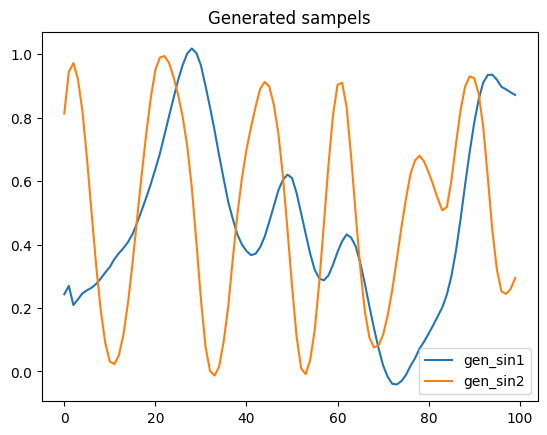

In [33]:
sample = 90
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
#plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

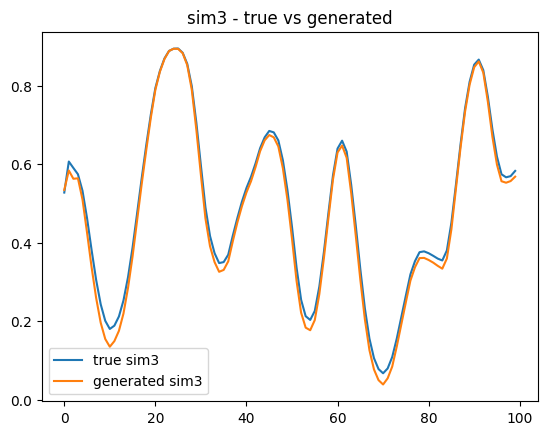

In [34]:
sample = 90
real_combo = (gen_z[sample][:,0] + gen_z[sample][:,1])/2
gen_combo = gen_z[sample][:,2]
plt.plot(real_combo, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.003s...
[t-SNE] Computed neighbors for 600 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.970288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.881638
[t-SNE] KL divergence after 300 iterations: 1.340324


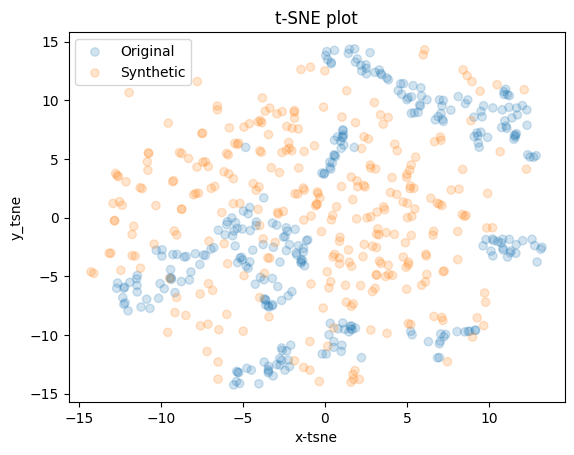

In [30]:
r = np.array([data[0].numpy() for data in testset])
visualization(r, gen_z, 'tsne')

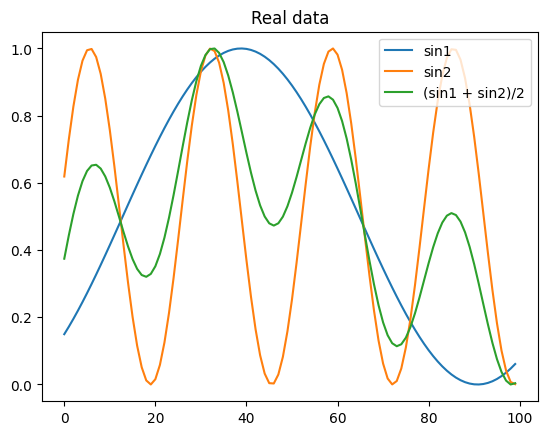

In [6]:
sample = trainset.__getitem__(2)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()

/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


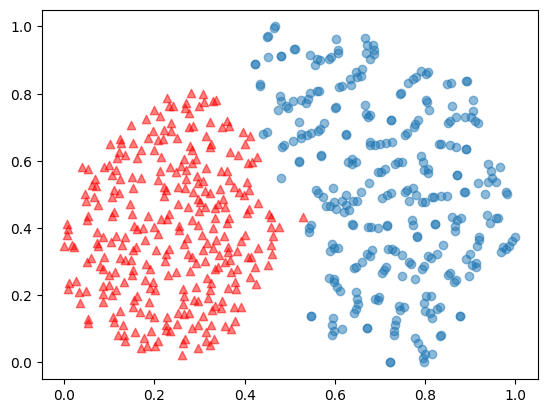

In [8]:
# %matplotlib inline
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

SIZE = len(testset)
train_r = np.array([data[0].numpy() for data in trainset])
r = np.array([data[0].numpy() for data in testset])
X = np.concatenate([gen_z, r], axis=0).reshape(2 * SIZE, -1)
X_embed = TSNE(n_components=2).fit_transform(X)
X_embed = MinMaxScaler().fit_transform(X_embed)

plt.scatter(X_embed[:len(testset), 0], X_embed[:len(testset), 1], c='r', marker='^', alpha=0.5)
plt.scatter(X_embed[len(testset):, 0], X_embed[len(testset):, 1], alpha=0.5)
# plt.show()
plt.show()

# Sinusoidal data with temporal and spatial relationship

200
torch.Size([100, 3])


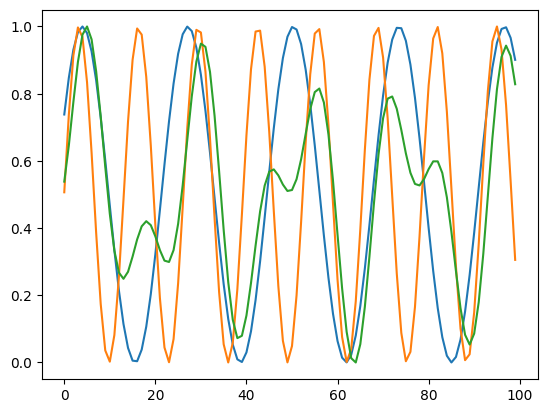

In [1]:
from timegan import *
trainset = TimeGANDatasetSinus(num=200, seq_len=100, features=3, temporal=True)
testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3, temporal=True)


print(len(trainset))
print(trainset[0][0].size())
plt.plot(trainset.__getitem__(0)[0][:,:])

In [2]:
device = "cpu"
feature_dim = trainset[0][0].size(1)
model = TimeGAN(feature_dim=feature_dim,
                hidden_dim=20,
                num_layers=2,
                padding_value=0.,
                Z_dim=100,
                max_seq_len=trainset[0][0].size(0),
                batch_size=64,
                device=torch.device(device))

timegan_trainer(model,
                trainset,
                batch_size=64,
                device=torch.device(device),
                learning_rate=0.0005,
                n_epochs=200,
                max_seq_len=trainset[0][0].size(0),
                dis_thresh=0.15
                )


Start Embedding Network Training


Epoch: 199, Loss: 0.0077: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



Start Training with Supervised Loss Only


Epoch: 199, Loss: 0.0084: 100%|██████████| 200/200 [01:02<00:00,  3.18it/s]



Start Joint Training


Epoch: 199, E: 0.1823, G: 4.0594, D: 1.4919: 100%|██████████| 200/200 [12:21<00:00,  3.71s/it]

Training Complete and Model Saved


In [3]:
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0),
                          100)


Generating Data...Done


In [ ]:
sample = 5
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

In [ ]:
r = np.array([data[0].numpy() for data in testset])
visualization(r, gen_z, 'pca')

In [7]:
data = sine_data_generation(1, 100, 3)

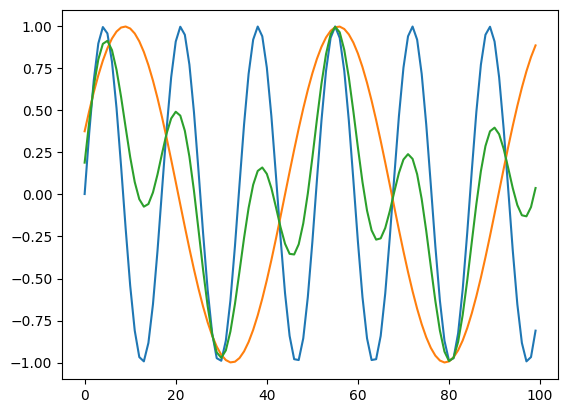

In [8]:
plt.plot(data[0])

In [20]:
from timegan import *

data = trainset.__getitem__(2)[0]
sin1, sin2, sin3 = data[:,0], data[:,1], data[:,2]

sin3_real = create_sin3(sin1, sin2, temporal=True)

In [21]:
sin3_real = minmaxscaler().fit_transform(torch.tensor([sin3_real]))[0]

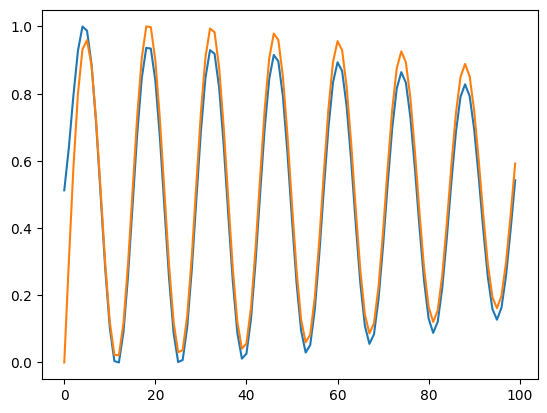

In [25]:
#plt.plot(sin1)
#plt.plot(sin2)
plt.plot(sin3)

plt.plot(sin3_real)


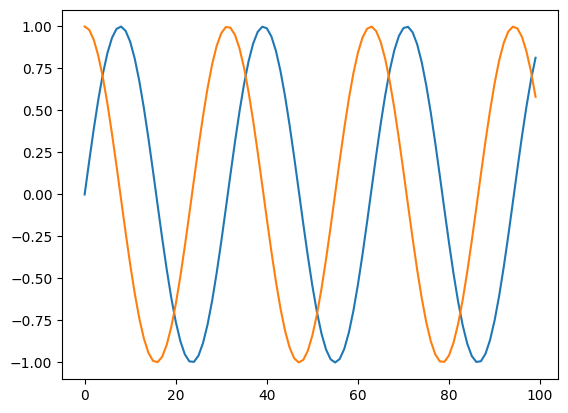

In [36]:
freq = 0.2 #np.random.uniform(0.05, 0.2)  # 0.1
phase = -np.pi/2#np.random.uniform(0, 3)  # 0.1
# Generate sine signal based on the drawn frequency and phase
plt.plot([np.sin(freq * j + 0) for j in range(100)])
plt.plot([np.sin(freq * j + phase) for j in range(100)])

In [8]:
sin1 = [np.sin(freq * j + 0) for j in range(100)]
sin2 = [np.sin(freq * j + phase) for j in range(100)]
temp = [sin1, sin2]
torch.tensor(temp)
temp_scaled = minmaxscaler().fit_transform(torch.tensor(temp))

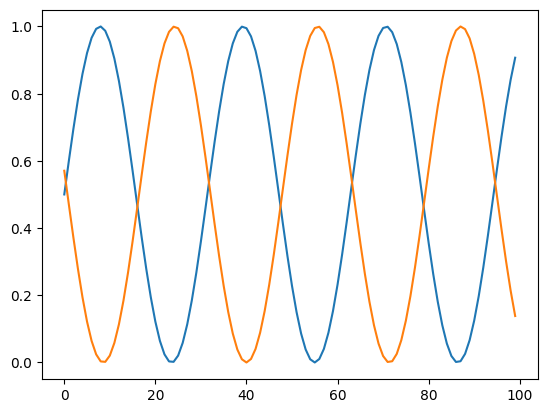

In [10]:
plt.plot(temp_scaled[0])
plt.plot(temp_scaled[1])

In [14]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [19]:
l = [1,2,3]
l.extend([3,2,1])

In [20]:
l

[1, 2, 3, 3, 2, 1]

In [2]:
from timegan import *
data = sine_data_generation(1,100,3)

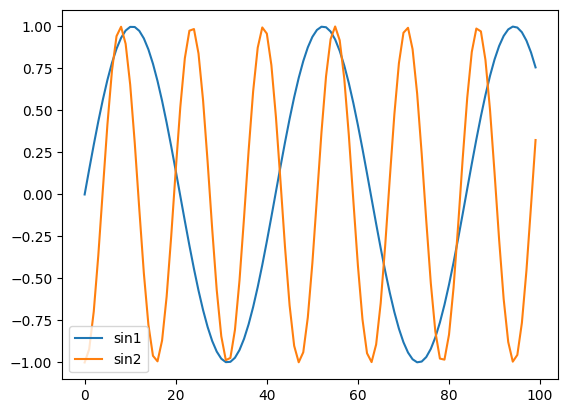

In [36]:
freq1 = 0.15#np.random.uniform(0.05, 0.15)
phase1 = 0#np.random.uniform(-np.pi/2, 0)
sin1 = np.sin(np.arange(100) * freq1 + phase1).tolist()

freq2 = 0.4#np.random.uniform(0.3, 0.4)
phase2 = -np.pi/2#np.random.uniform(0, np.pi / 2)
sin2 = np.sin(np.arange(100) * freq2 + phase2).tolist()
plt.plot(sin1, label="sin1")
plt.plot(sin2, label="sin2")
plt.legend()